In [1]:
import pandas as pd
import s3fs
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from sklearn.model_selection import train_test_split

# Data reading
The raw data are stored in the storage system S3 through SSP cloud.

In [2]:
key_id = 'GMM5QGDEB0TR3419274E'
access_key = 'NcEZ7tcQcu+ceuJCJNnIlkHwlruCk4cM7B0fYlyu'
token = "eyJhbGciOiJIUzUxMiIsInR5cCI6IkpXVCJ9.eyJhY2Nlc3NLZXkiOiJHTU01UUdERUIwVFIzNDE5Mjc0RSIsImFsbG93ZWQtb3JpZ2lucyI6WyIqIl0sImF1ZCI6WyJtaW5pby1kYXRhbm9kZSIsIm9ueXhpYSIsImFjY291bnQiXSwiYXV0aF90aW1lIjoxNjU0OTAwMjM1LCJhenAiOiJvbnl4aWEiLCJlbWFpbCI6Imlkcmlzc2Eua29ua29ib0BlbnNhZS5mciIsImVtYWlsX3ZlcmlmaWVkIjp0cnVlLCJleHAiOjE2NTQ5ODY2MzYsImZhbWlseV9uYW1lIjoiS09OS09CTyIsImdpdmVuX25hbWUiOiJJZHJpc3NhIiwiZ3JvdXBzIjpbXSwiaWF0IjoxNjU0OTAwMjM1LCJpc3MiOiJodHRwczovL2F1dGgubGFiLnNzcGNsb3VkLmZyL2F1dGgvcmVhbG1zL3NzcGNsb3VkIiwianRpIjoiYmQzYmYxMmUtODE0OC00ZTg3LWJmYjctMWI3MGE3ZmVkN2NhIiwibG9jYWxlIjoiZW4iLCJuYW1lIjoiSWRyaXNzYSBLT05LT0JPIiwibm9uY2UiOiJmZTE4YzVhNS1iY2FiLTQ2OGYtOGRiZi02ZDQ0ZjdlMThlY2EiLCJwb2xpY3kiOiJzdHNvbmx5IiwicHJlZmVycmVkX3VzZXJuYW1lIjoiaWtvbmtvYm8iLCJyZWFsbV9hY2Nlc3MiOnsicm9sZXMiOlsib2ZmbGluZV9hY2Nlc3MiLCJ1bWFfYXV0aG9yaXphdGlvbiJdfSwicmVzb3VyY2VfYWNjZXNzIjp7ImFjY291bnQiOnsicm9sZXMiOlsibWFuYWdlLWFjY291bnQiLCJtYW5hZ2UtYWNjb3VudC1saW5rcyIsInZpZXctcHJvZmlsZSJdfX0sInNjb3BlIjoib3BlbmlkIHByb2ZpbGUgZ3JvdXBzIGVtYWlsIiwic2Vzc2lvbl9zdGF0ZSI6IjgzYmFlYWJiLWFmMmMtNDVkZi1hYjhlLTkyZTI2MDY3YjAxNiIsInNpZCI6IjgzYmFlYWJiLWFmMmMtNDVkZi1hYjhlLTkyZTI2MDY3YjAxNiIsInN1YiI6IjBiMWM2YWM4LTcyZTQtNDkxYy1iMmYwLTIwOGZmYjhiMWNiNSIsInR5cCI6IkJlYXJlciJ9.WP5CVpDRfH6--hrLLE_PNgbqHZjV-kyCktngFICwctqSmNuJS8P1CKelbX7h_qKNwNVHZgp3cjq-QDfzqxouLA"

fs = s3fs.S3FileSystem(client_kwargs={'endpoint_url': 'https://'+'minio.lab.sspcloud.fr'}, key = key_id, secret = access_key, token = token)

comms_df = pd.read_sas(fs.open("ikonkobo/commsdata/commsdata.sas7bdat"), format='sas7bdat')

In [3]:
comms_df.shape

(56557, 128)

In [4]:
comms_df

,Customer_ID,upsell_xsell,churn,lifetime_value,avg_arpu_3m,acct_age,billing_cycle,nbr_contracts_ltd,credit_class,sales_channel,...,pymts_late_ltd,calls_care_ltd,MB_Data_Usg_M04,MB_Data_Usg_M05,MB_Data_Usg_M06,MB_Data_Usg_M07,MB_Data_Usg_M08,MB_Data_Usg_M09,seconds_of_data_norm,seconds_of_data_log
0,471.0,0.0,0.0,1693.8,44.980000,55.000000,4.0,7.0,b'prime',b'Indirect',...,5.0,57.0,0.0,0.0,0.0,0.0,0.0,0.0,60.0,4.110874
1,1057.0,0.0,0.0,38682.5,44.989330,47.000000,3.0,5.0,b'prime',b'Indirect',...,5.0,115.0,0.0,0.0,0.0,0.0,330.0,646.0,48300.0,10.785208
2,1177.0,0.0,0.0,5526.4,51.775434,46.176471,7.0,4.8,b'prime',b'Retail',...,5.0,78.0,0.0,0.0,0.0,0.0,0.0,0.0,14700.0,9.595671
3,1181.0,0.0,0.0,505.6,51.775434,75.000000,7.0,4.8,b'prime',b'Retail',...,5.0,76.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
4,1185.0,0.0,1.0,9143.2,83.320000,50.000000,5.0,3.0,b'prime',b'Indirect',...,5.0,80.0,0.0,0.0,0.0,0.0,0.0,0.0,15840.0,9.670357
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56552,3999397.0,0.0,0.0,1151.3,54.980000,58.000000,11.0,4.0,b'prime',b'Indirect',...,0.0,67.0,1562.0,51.0,516.0,1.0,70.0,0.0,6142.0,8.723069
56553,3999465.0,0.0,0.0,3672.8,37.769990,69.000000,11.0,2.0,b'prime',b'National Sales',...,4.0,68.0,137.0,4.0,342.0,331.0,592.0,46.0,7625.0,8.939319
56554,3999574.0,0.0,0.0,1112.8,54.655000,52.000000,7.0,3.0,b'risky',b'National Sales',...,0.0,71.0,188.0,163.0,4.0,11.0,1.0,16.0,1113.0,7.015712
56555,3999770.0,0.0,0.0,1126.5,64.980000,29.000000,1.0,2.0,b'prime',b'Indirect',...,8.0,77.0,0.0,2.0,1.0,0.0,3.0,1.0,3089.0,8.035926


In [5]:
comms_df.churn.describe()

count    56557.000000
mean         0.121329
std          0.326512
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
Name: churn, dtype: float64

# Data preprocessing

The project focuses on churn prediction and the dataset has 2 potential target variables which are 
+ *churn* : indicates wheteher customer churned 
+ *upsell_xsell* : indicates customer’s flag for cross-sell or up-sell. 
Since we focus on churn prediction, *upsell_xsell* will be deleted. 

Furthermore, the variables listed below are useless for predictive modeling and will be rejected :
+ city
+ city_lat
+ city_long
+ data_usage_amt
+ mou_onnet_6m_normal
+ mou_roam_6m_normal
+ region_lat
+ region_long
+ state_lat
+ state_long
+ tweedie_adjusted

In addition, we notice that character variables are showed in this format b'prime'. We will suppress characters 'b' and '.

In [6]:
comms_df.drop(["upsell_xsell", "city", "city_lat", "city_long", "data_usage_amt", "mou_onnet_6m_normal", "mou_roam_6m_normal", "region_lat",
"region_long", "state_lat", "state_long", "tweedie_adjusted"], axis=1, inplace=True)

In [7]:
list_vars_object = list(comms_df.select_dtypes(exclude = ['int64', 'float64']).columns)

for var in list_vars_object:
    comms_df[var] = comms_df[var].apply(lambda x : x.decode("utf-8"))

In [8]:
df_val_mqtes = comms_df.isnull().sum().to_frame().reset_index()
df_val_mqtes.columns = ["variable", "nb_valeur_manquante"]
df_val_mqtes = df_val_mqtes[df_val_mqtes.nb_valeur_manquante > 0].reset_index(drop=True)
df_val_mqtes['pourcent_valeur_manquante'] = round(100 * df_val_mqtes['nb_valeur_manquante'] / comms_df.shape[0], 2)
df_val_mqtes = df_val_mqtes.sort_values('nb_valeur_manquante', ascending=False).reset_index(drop=True)


In [9]:
list(df_val_mqtes.variable)

['mou_roam_pct_MOM',
 'mou_onnet_pct_MOM',
 'mou_total_pct_MOM',
 'seconds_of_data_log',
 'tot_drpd_pr1',
 'nbr_data_cdrs',
 'data_device_age',
 'cs_afr_amer',
 'cs_hispanic',
 'cs_other',
 'cs_ttl_hhlds',
 'cs_caucasian',
 'cs_ttl_rural',
 'cs_ttl_male',
 'cs_ttl_female',
 'cs_ttl_mdage',
 'cs_ttl_urban',
 'cs_ttl_pop',
 'data_prem_chrgs_curr',
 'avg_overage_chrgs_3m',
 'avg_data_prem_chrgs_3m',
 'avg_data_chrgs_3m',
 'tot_voice_chrgs_curr',
 'tot_overage_chgs',
 'avg_arpu_3m',
 'MB_Data_Usg_M09',
 'cs_pct_home_owner',
 'cs_med_home_value',
 'mb_data_ndist_mo6m']

In [10]:
l_ = [var for var in list(df_val_mqtes.variable) if len(comms_df[var].unique()) < 50]

l_

['tot_drpd_pr1']

In [11]:
comms_df["tot_drpd_pr1"].value_counts(ascending=False).to_frame().reset_index().iloc[0, 0]

2.0

In [12]:
comms_df.values

array([[471.0, 0.0, 1693.8, ..., 0.0, 60.0, 4.110873864173311],
       [1057.0, 0.0, 38682.5, ..., 646.0, 48300.0, 10.785207543360087],
       [1177.0, 0.0, 5526.4, ..., 0.0, 14700.0, 9.595670797663967],
       ...,
       [3999574.0, 0.0, 1112.8, ..., 16.0, 1113.0, 7.01571242048723],
       [3999770.0, 0.0, 1126.5, ..., 1.0, 3089.0, 8.035926369891792],
       [3999922.0, 0.0, -114.5, ..., 1.0, 5900.0, 8.682877107057168]],
      dtype=object)

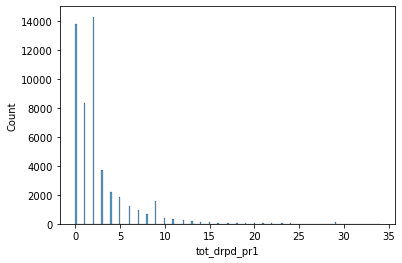

In [13]:
sns.histplot(comms_df[df_val_mqtes.variable[4]])#, bins=100)
plt.show()

# Data splitting

In [14]:
comms_df.churn.describe()

count    56557.000000
mean         0.121329
std          0.326512
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
Name: churn, dtype: float64

The target variable churn seems to not have missing values. The dataset contains 12.13 % of customers churned. We will split the dataset to 70 % for training and 30% for test using *churn* as startify variable.

In [15]:
X = comms_df.drop(columns=["churn"])
y = comms_df.churn

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, stratify=y, random_state=42)

In [17]:
train = X_train 
train["churn"] = y_train

test = X_test 
test["churn"] = y_test

In [18]:
test.to_csv("/home/coder/.config/code-server/telco_churn/data/raw/test.csv", index=False)
train.to_csv("/home/coder/.config/code-server/telco_churn/data/raw/train.csv", index=False)

OSError: Cannot save file into a non-existent directory: '/home/coder/.config/code-server/telco_churn/data/raw'

In [ ]:
df_test = pd.read_csv("/home/coder/.config/code-server/telco_churn/data/raw/test.csv")
df_test